In [1]:
import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

True NVIDIA RTX A4500


Train

In [2]:
import os
import random
import base64
from ollama import Client

def encode_image_to_base64(image_path: str) -> str:
    with open(image_path, "rb") as f:
        bts = f.read()
    return base64.b64encode(bts).decode("utf-8")


def parse_label_from_folder(folder_name: str) -> float | None:
    if not folder_name.startswith("pm25_"):
        return None
    try:
        return float(folder_name.split("_", 1)[1])
    except ValueError:
        return None


def gather_all_image_labels(data_dir: str) -> list[tuple[str, float]]:
    records: list[tuple[str, float]] = []
    for entry in os.listdir(data_dir):
        subfolder = os.path.join(data_dir, entry)
        if not os.path.isdir(subfolder):
            continue

        label = parse_label_from_folder(entry)
        if label is None:
            continue

        for fname in os.listdir(subfolder):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                full_path = os.path.join(subfolder, fname)
                records.append((full_path, label))
    return records


def few_shot_pm25_with_label_in_user(
    data_dir: str,
    num_examples: int,
    target_image_path: str,
    model_name: str = "gemma3:27b"
) -> str:
    """
    Feed a few training image-label pairs and a new target image to the model,
    using visual environmental reasoning to predict PM2.5.
    """
    all_records = gather_all_image_labels(data_dir)
    if not all_records:
        raise ValueError(f"No folders named pm25_* found in {data_dir}.")

    sampled = random.sample(all_records, min(num_examples, len(all_records)))

    intro_prompt = """
You are an air quality estimation model. Your task is to predict the PM2.5 level (in μg/m³)
from traffic camera images taken during the daytime. You will be trained on images
showing various environmental conditions, including sunlight intensity, shadow clarity,
sky color, visibility, and overall lighting conditions.

When analyzing an image, consider the following features:

- Sunlight intensity (bright, soft, harsh, diffused)
- Shadow clarity (sharp vs soft shadows)
- Sky color and clearness (blue, white, gray, hazy)
- Visibility (how clearly distant buildings or hills can be seen)
- Road and building contrast, reflections or glare
- Overall lighting conditions and time of day

Here are several examples with known PM2.5 values:
"""

    messages: list[dict] = [{"role": "user", "content": intro_prompt.strip()}]

    print(f"Feeding {len(sampled)} training examples to the model:")
    for img_path, label in sampled:
        filename = os.path.basename(img_path)
        print(f"  - {filename} (PM2.5 = {label})")
        b64 = encode_image_to_base64(img_path)
        messages.append({
            "role": "user",
            "content": f"This image was taken during the day and has a PM2.5 value of {label} μg/m³.",
            "images": [b64]
        })

    # Add the final target image for prediction
    target_b64 = encode_image_to_base64(target_image_path)
    messages.append({
        "role": "user",
        "content": "Now analyze this new image and predict the PM2.5 level (in μg/m³).",
        "images": [target_b64]
    })

    client = Client(host="http://127.0.0.1:11434")
    response = client.chat(model=model_name, messages=messages)
    return response.message.content



In [3]:
parent_folder = "/home/jasonrao/Documents/TCAM/img_src"
test_image = "/home/jasonrao/Documents/TCAM/img_src/pm25_5/2021-10-07T22_13_15+00_00.jpg"
N = 200

prediction = few_shot_pm25_with_label_in_user(
    data_dir=parent_folder,
    num_examples=N,
    target_image_path=test_image
)

print("Gemma 3 predicted →", prediction)

Feeding 200 training examples to the model:
  - 2021-09-16T22_32_54+00_00.jpg (PM2.5 = 25.0)
  - 2021-09-29T22_33_33+00_00.jpg (PM2.5 = 15.0)
  - 2021-10-24T21_18_40+00_00.jpg (PM2.5 = 5.0)
  - 2021-09-02T21_57_14+00_00.jpg (PM2.5 = 35.0)
  - 2021-09-07T18_21_45+00_00.jpg (PM2.5 = 35.0)
  - 2021-11-10T22_42_43+00_00.jpg (PM2.5 = 25.0)
  - 2021-11-09T20_13_37+00_00.jpg (PM2.5 = 15.0)
  - 2021-12-13T19_54_23+00_00.jpg (PM2.5 = 25.0)
  - 2021-11-08T21_16_12+00_00.jpg (PM2.5 = 15.0)
  - 2021-11-20T19_04_01+00_00.jpg (PM2.5 = 15.0)
  - 2021-09-20T20_57_10+00_00.jpg (PM2.5 = 25.0)
  - 2021-11-01T19_45_03+00_00.jpg (PM2.5 = 5.0)
  - 2021-10-23T20_59_49+00_00.jpg (PM2.5 = 5.0)
  - 2021-11-04T20_00_43+00_00.jpg (PM2.5 = 5.0)
  - 2021-10-12T22_05_57+00_00.jpg (PM2.5 = 5.0)
  - 2021-11-08T19_30_16+00_00.jpg (PM2.5 = 15.0)
  - 2021-10-25T22_10_10+00_00.jpg (PM2.5 = 5.0)
  - 2021-11-13T22_42_21+00_00.jpg (PM2.5 = 25.0)
  - 2021-11-20T21_22_35+00_00.jpg (PM2.5 = 15.0)
  - 2021-10-02T22_41_04+00_00.j

Without Weather Infomation

In [ ]:
import base64
from ollama import Client
import time
time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print(time)

def get_weather(location):
    pass

def predict_pm25_over_ssh(image_path: str) -> str:
    """
    Sends <image_path> (as raw Base64) to gemma3:27b via the Ollama daemon
    bound locally at 127.0.0.1:11434. Returns the model's text reply.
    """
    with open(image_path, "rb") as f:
        img_bytes = f.read()
    img_b64 = base64.b64encode(img_bytes).decode("utf-8")
    print(image_path)  # Print first 50 chars of Base64 for debugging

    client = Client(host="http://127.0.0.1:11434")

    prompt = """
You are an air quality estimation model. Your task is to predict the PM2.5 value based on a detailed visual description of a daytime traffic camera image.

Focus on specific features in the environment that may affect PM2.5 levels, such as:
- Sunlight intensity (bright, soft, harsh, diffused)
- Sky condition (clear, pale blue, gray, hazy)
- Visibility (how far distant objects can be seen)
- Shadow sharpness (soft vs sharp shadows)
- Reflection/glare on surfaces
- Presence of haze or smog in the background
- Overall lighting and time of day
- Dryness of road and surroundings

Here are examples to guide your reasoning:

1. "Early morning, clear sky, soft sunlight, no haze, long shadows, distant hills clearly visible" → PM2.5: 6  
2. "Late morning, strong sun causing glare on cars, faint haze over mountains, shadows are sharp, clear street" → PM2.5: 18  
3. "Noon, harsh sunlight, slight atmospheric haze, far buildings slightly faded, blue sky turning pale" → PM2.5: 32  
4. "Afternoon, moderate sunlight, white haze visible at horizon, sky looks washed out, distant hills are blurry" → PM2.5: 72  
5. "Late afternoon, warm sunlight tone, background visibility low due to visible haze, shadows are still visible but softer" → PM2.5: 98  

Now analyze the attached image and estimate the PM2.5 level in μg/m³. showing your output as a single number with the unit μg/m³. and what you see in the image.
if you are not sure, just say "I don't know".
"""

    messages = [
        {
            "role": "user",
            "content": prompt,
            "images": [img_b64],
        }
    ]

    response = client.chat(model="gemma3:27b", messages=messages)
    return response.message.content

2025-06-10 14:25:27


In [ ]:

    
img_path = "/home/jasonrao/Documents/TCAM/image.png"
prediction = predict_pm25_over_ssh(img_path)
print(f"Gemma 3 → {os.path.basename(img_path)}: {prediction}")

/home/jasonrao/Documents/TCAM/image.png
Gemma 3 → image.png: Based on the image, here's my analysis:

The image shows a daytime scene with moderate sunlight. The sky appears pale blue, and there's a noticeable haze or smog present, particularly visible in the background where distant objects seem faded and blurry. Shadows are not very sharp, indicating diffused sunlight. The overall visibility seems moderately reduced due to the haze.

Considering these factors, I estimate the PM2.5 level to be **48 μg/m³**.


With OpenWeather API

In [40]:
import base64
from ollama import Client
import requests
from PIL import Image
import pytesseract
from datetime import datetime
import geopy
from geopy.geocoders import Nominatim
import os

# OpenWeather API key
OPENWEATHER_API_KEY = "ac2ea0aaefa10c626230f081dc63c3eb"
def recognize_date_time_from_image(image_path: str) -> str:
    """
    Uses Gemma 3 to recognize the date and time from the traffic camera image.
    Returns the recognized date and time in 'YYYY-MM-DD HH:MM:SS' format or 'Unknown' if not found.
    """
    try:
        with open(image_path, "rb") as f:
            img_bytes = f.read()
        img_b64 = base64.b64encode(img_bytes).decode("utf-8")

        # Prompt for date and time
        prompt_date_time = (
            "You are an expert at reading timestamps from traffic camera images. "
            "Please extract and return the date and time (in 'YYYY-MM-DD HH:MM:SS' format) "
            "visible in the attached image. If you cannot find a date and time, reply with 'Unknown'."
        )

        client = Client(host="http://127.0.0.1:11434")

        # Send the image and prompt to Gemma 3
        messages_date_time = [
            {
                "role": "user",
                "content": prompt_date_time,
                "images": [img_b64],
            }
        ]
        response_date_time = client.chat(model="gemma3:27b", messages=messages_date_time)
        date_time = response_date_time.message.content.strip()

        return date_time
    except Exception as e:
        print(f"Error recognizing date and time: {e}")
        return "Unknown"


def get_weather(lat: float, lon: float, date_time: str) -> dict:
    """
    Fetches weather information from the OpenWeather API for the given location and date/time.
    """
    try:
        url = f"http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={OPENWEATHER_API_KEY}&units=metric&dt={int(datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S').timestamp())}"
        print(url)  # Debugging: print the URL being requested
        response = requests.get(url)
        if response.status_code == 200:
            weather_data = response.json()
            # print(weather_data)  # Debugging: print the raw weather data
            return {
                "temperature": weather_data["main"]["temp"],
                "humidity": weather_data["main"]["humidity"],
                "weather": weather_data["weather"][0]["description"],
                "wind_speed": weather_data["wind"]["speed"],
                "visibility": weather_data["visibility"]
            }
        else:
            print(f"Failed to fetch weather data: {response.status_code}")
            return {}
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return {}

def predict_pm25_with_weather(image_path: str, lat: float, lon: float) -> str:
    """
    Predicts PM2.5 using the image and integrates weather information.
    """
    try:
        # Recognize date and time from the image
        date_time = recognize_date_time_from_image(image_path)
        print(f"Recognized date and time: {date_time}")
        
        # Fetch weather information
        weather_info = get_weather(lat, lon, date_time)
        print(f"Weather info: {weather_info}")
        
        # Encode image to Base64
        with open(image_path, "rb") as f:
            img_bytes = f.read()
        img_b64 = base64.b64encode(img_bytes).decode("utf-8")
        
        # Prepare prompt
        prompt = f"""
        You are an air quality estimation model. Your task is to predict the PM2.5 value based on a detailed visual description of a daytime traffic camera image.
        The image was taken at {date_time} in the following location:
        city: {city}
        
        The weather information is as follows:
        - Temperature: {weather_info.get('temperature', 'Unknown')} °C
        - Humidity: {weather_info.get('humidity', 'Unknown')}%
        - Weather: {weather_info.get('weather', 'Unknown')}
        - Wind Speed: {weather_info.get('wind_speed', 'Unknown')} m/s
        - Visibility: {weather_info.get('visibility', 'Unknown')} m

        Focus on specific features in the environment that may affect PM2.5 levels, such as:
        - Sunlight intensity (bright, soft, harsh, diffused)
        - Sky condition (clear, pale blue, gray, hazy)
        - Visibility (how far distant objects can be seen)
        - Shadow sharpness (soft vs sharp shadows)
        - Reflection/glare on surfaces
        - Presence of haze or smog in the background
        
        Now analyze the attached image and estimate the PM2.5 level in μg/m³. If you are not sure, just say "I don't know."         
        only return the PM2.5 value as a single number with the unit μg/m³.
        """
        # print(f"Prompt: {prompt}")  # Debugging: print the prompt being sent
        
        # Send the image and prompt to the model
        client = Client(host="http://127.0.0.1:11434")
        messages = [
            {
                "role": "user",
                "content": prompt,
                "images": [img_b64],
            }
        ]
        response = client.chat(model="gemma3:27b", messages=messages)
        return response.message.content
    except Exception as e:
        print(f"Error during prediction: {e}")
        return "Error"

# Example usage
# # Use Gemma 3 to identify the location and date/time from the image
# def recognize_location_and_time_from_image(image_path: str) -> tuple:
#     """
#     Uses Gemma 3 to recognize the location and date/time from the image.
#     Returns a tuple: (location, date_time)
#     """
#     try:
#         with open(image_path, "rb") as f:
#             img_bytes = f.read()
#         img_b64 = base64.b64encode(img_bytes).decode("utf-8")

#         # Prompt for location
#         prompt_location = (
#             "You are an expert at identifying locations from traffic camera images. "
#             "Please analyze the attached image and return the most likely city or location name. "
#             "If you cannot determine the location, reply with 'Unknown'."
#         )
#         # Prompt for date/time
#         prompt_time = (
#             "You are an expert at reading timestamps from traffic camera images. "
#             "Please extract and return the date and time (in 'YYYY-MM-DD HH:MM:SS' format) "
#             "visible in the attached image. If you cannot find a date and time, reply with 'Unknown'."
#         )

#         client = Client(host="http://127.0.0.1:11434")

#         # Get location
#         messages_location = [
#             {
#                 "role": "user",
#                 "content": prompt_location,
#                 "images": [img_b64],
#             }
#         ]
#         response_location = client.chat(model="gemma3:27b", messages=messages_location)
#         location = response_location.message.content.strip()

#         # Get date/time
#         messages_time = [
#             {
#                 "role": "user",
#                 "content": prompt_time,
#                 "images": [img_b64],
#             }
#         ]
#         response_time = client.chat(model="gemma3:27b", messages=messages_time)
#         date_time = response_time.message.content.strip()

#         return location, date_time
#     except Exception as e:
#         print(f"Error recognizing location and time: {e}")
#         return "Unknown", "Unknown"

# location, date_time = recognize_location_and_time_from_image(image_path)
# print(f"Recognized location: {location}, date/time: {date_time}")

image_path = "/home/jasonrao/Documents/TCAM/Screenshot 2025-06-16 at 10.14.02 AM.png"
geolocator = Nominatim(user_agent="pm25_predictor")  # Change to the desired city or location
city = input("Enter the city name (default is Lindon): ") or "Lindon"
location_obj = geolocator.geocode(city)
if location_obj:
    city = location_obj.address
    lat, lon = location_obj.latitude, location_obj.longitude
    print(f"City: {city}, Latitude: {lat}, Longitude: {lon}")
else:
    lat, lon = None, None
    print("Could not geocode city name.")
prediction = predict_pm25_with_weather(image_path, lat, lon)
print(f"Gemma 3 → {os.path.basename(image_path)}: {prediction}")

City: Boston, Suffolk County, Massachusetts, United States, Latitude: 42.3554334, Longitude: -71.060511
Recognized date and time: 2025-06-16 12:13:34
http://api.openweathermap.org/data/2.5/weather?lat=42.3554334&lon=-71.060511&appid=ac2ea0aaefa10c626230f081dc63c3eb&units=metric&dt=1750097614
Weather info: {'temperature': 20.59, 'humidity': 84, 'weather': 'moderate rain', 'wind_speed': 4.02, 'visibility': 10000}
Gemma 3 → Screenshot 2025-06-16 at 10.14.02 AM.png: 12.5 μg/m³


Detect Where the Image was Took

In [4]:
def recognize_city_from_image(image_path: str) -> str:
    try:
        with open(image_path, "rb") as f:
            img_bytes = f.read()
        img_b64 = base64.b64encode(img_bytes).decode("utf-8")

        # Prompt for city name
        prompt_city = (
            "You are an expert at identifying city names from traffic camera images. "
            "Please analyze the attached image and return the most likely city name. "
            "If you cannot determine the city, reply with 'Unknown'."
        )

        client = Client(host="http://127.0.0.1:11434")

        # Get city name
        messages_city = [
            {
                "role": "user",
                "content": prompt_city,
                "images": [img_b64],
            }
        ]
        response_city = client.chat(model="gemma3:27b", messages=messages_city)
        city = response_city.message.content.strip()

        return city
    except Exception as e:
        print(f"Error recognizing city: {e}")
        return "Unknown"

# Example usage
image_path = "/home/jasonrao/Documents/TCAM/Screenshot from 2025-06-11 13-19-36.png"
city = recognize_city_from_image(image_path)
print(f"Recognized city: {city}")

Recognized city: Based on the distinctive architecture of the building visible in the background, particularly the prominent spires, this image is very likely taken in **Logan, Utah**. The building is likely the Logan Utah Temple of The Church of Jesus Christ of Latter-day Saints. The street signs in the image also indicate the location.


This code is designed to predict PM2.5 levels from traffic camera images using the Gemma 3 model via the Ollama API. It includes functionality to gather training data, encode images, and make predictions based on visual features and weather conditions. The code also allows for recognizing date, time, and city from images, enhancing the prediction context. Make sure to have the necessary libraries installed and the Ollama server running locally for this code to function correctly.

In [ ]:
# from openaq import OpenAQ

# client = OpenAQ(api_key='829e1a1d5340d640e5f617ce26ed769a49ca86f8a3ba6bb494409e97dfa52e9d')

# location = client.locations.get(5818)

# client.close()

# print(location)


LocationsResponse(headers=Headers(x_ratelimit_limit=60, x_ratelimit_remaining=59, x_ratelimit_used=1, x_ratelimit_reset=60), meta=Meta(name='openaq-api', website='/', page=1, limit=100, found=1), results=[Location(id=5818, name='Herriman #3', locality='Salt Lake City', timezone='America/Denver', country=CountryBase(id=155, code='US', name='United States'), owner=OwnerBase(id=4, name='Unknown Governmental Organization'), provider=ProviderBase(id=119, name='AirNow'), is_mobile=False, is_monitor=True, instruments=[InstrumentBase(id=2, name='Government Monitor')], sensors=[SensorBase(id=4272170, name='no ppm', parameter=ParameterBase(id=35, name='no', units='ppm', display_name='NO')), SensorBase(id=15815, name='no2 ppm', parameter=ParameterBase(id=7, name='no2', units='ppm', display_name='NO₂')), SensorBase(id=4272237, name='nox ppm', parameter=ParameterBase(id=19840, name='nox', units='ppm', display_name='NOx')), SensorBase(id=15814, name='o3 ppm', parameter=ParameterBase(id=10, name='o3'

In [3]:
import base64
from ollama import Client
import requests
import csv
from datetime import datetime
from zoneinfo import ZoneInfo
from geopy.geocoders import Nominatim
import os
import glob
import re

# Visual Crossing API info
VC_API_KEY = "JN3RL65EBCUWKPSPLD9Q42LKG"
VC_UNIT_GROUP = "us"
VC_INCLUDE = "hours"

def fetch_weather_day(lat: float, lon: float, date: datetime) -> dict:
    """
    Fetches hourly weather data for the whole day from Visual Crossing.
    """
    date_str = date.strftime("%Y-%m-%dT00:00:00")
    url = (
        f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
        f"{lat},{lon}/{date_str}"
        f"?unitGroup={VC_UNIT_GROUP}&include={VC_INCLUDE}"
        f"&key={VC_API_KEY}&contentType=csv"
    )
    print(f"📡 Fetching weather data for {date_str}...\n{url}")

    weather_dict = {}
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        lines = resp.text.splitlines()
        reader = csv.DictReader(lines)
        for row in reader:
            hour_key = row.get("datetime")
            if hour_key:
                weather_dict[hour_key] = {
                    "temperature": row.get("temp", "Unknown"),
                    "humidity": row.get("humidity", "Unknown"),
                    "wind_speed": row.get("windspeed", "Unknown"),
                    "visibility": row.get("visibility", "Unknown"),
                    "description": row.get("conditions", "Unknown"),
                }
    except Exception as e:
        print(f"❌ Error fetching from Visual Crossing: {e}")

    return weather_dict

def predict_pm25_with_weather(image_path: str, dt: datetime, city: str, weather_hourly: dict) -> str:
    fname = os.path.basename(image_path)
    dt_key = dt.strftime("%Y-%m-%dT%H:00:00")
    weather = weather_hourly.get(dt_key, {
        "temperature": "Unknown",
        "humidity": "Unknown",
        "wind_speed": "Unknown",
        "visibility": "Unknown",
        "description": "Unknown"
    })

    img_b64 = base64.b64encode(open(image_path, "rb").read()).decode("utf-8")
    date_str = dt.strftime("%Y-%m-%d %H:%M:%S")
    print(image_path)
    print(date_str)

    prompt = f"""
    You are an air quality estimation model. Your task is to predict the PM2.5 value based on a detailed visual description of a daytime traffic camera image.
    The image was taken at {date_str} in the following location:
    City: {city}

    The weather information is as follows:
    - Temperature: {weather.get('temperature', 'Unknown')} °F
    - Humidity: {weather.get('humidity', 'Unknown')}%
    - Weather: {weather.get('description', 'Unknown')}
    - Wind Speed: {weather.get('wind_speed', 'Unknown')} mph
    - Visibility: {weather.get('visibility', 'Unknown')} miles

    Focus on specific features in the environment that may affect PM2.5 levels, such as:
    - Sunlight intensity (bright, soft, harsh, diffused)
    - Sky condition (clear, pale blue, gray, hazy)
    - Visibility (how far distant objects can be seen)
    - Shadow sharpness (soft vs sharp shadows)
    - Reflection/glare on surfaces
    - Presence of haze or smog in the background

    Now analyze the attached image and estimate the PM2.5 level in μg/m³. If you are not sure, just say "I don't know." and explain why.
    """
    # print(f"Prompt: {prompt}")  # Debugging: print the prompt being sent
    client = Client(host="http://127.0.0.1:11434")
    messages = [
            {
                "role": "user",
                "content": prompt,
                "images": [img_b64],
            }
        ]
    response = client.chat(model="gemma3:27b", messages=messages)
    return response.message.content

# === MAIN EXECUTION ===
geolocator = Nominatim(user_agent="pm25_vc")
city_input = input("City (default Lindon, UT): ") or "Herriman, UT"
loc = geolocator.geocode(city_input)
if not loc:
    print("City not found.")
    exit()

city = loc.address
lat, lon = loc.latitude, loc.longitude
print(f"📍 Using location: {city} ({lat}, {lon})")

# === Gather Images ===
folder_path = "/home/jasonrao/Documents/images/17369.sqsh/2025/05/10"
jpg_files = glob.glob(os.path.join(folder_path, "*.jpg"))
if not jpg_files:
    print("No images found.")
    exit()

# === Extract date from first image ===
first_fname = os.path.basename(jpg_files[0])
match = re.match(r"(\d{4}-\d{2}-\d{2})T", first_fname)
if not match:
    print("Cannot extract date from filename.")
    exit()
date_only = datetime.strptime(match.group(1), "%Y-%m-%d")

# === Fetch weather once for the whole day ===
weather_hourly = fetch_weather_day(lat, lon, date_only)

# === Predict PM2.5 ===
results = {}
for img_path in jpg_files:
    fname = os.path.basename(img_path)
    m = re.match(r"(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})\+00_00", fname)  # expecting UTC format
    if m:
        try:
            ts = m.group(1).replace("_", ":")
            dt_utc = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S").replace(tzinfo=ZoneInfo("UTC"))
            dt_local = dt_utc.astimezone(ZoneInfo("America/Denver"))  # Convert UTC → MDT
        except Exception as e:
            print(f"⚠️ Failed to parse timestamp from {fname}, skipping.")
            continue
    else:
        print(f"⚠️ No timestamp match in {fname}, skipping.")
        continue

    prediction = predict_pm25_with_weather(img_path, dt_local, city, weather_hourly)
    try:
        value = float(re.findall(r"[\d.]+", prediction)[0])
    except:
        value = None

    results[dt_local.isoformat()] = value
    print(f"{fname} → {prediction}")

print("\n✅ Final PM2.5 Predictions:")
for k, v in results.items():
    print(f"{k}: {v}")

# Save results to CSV
i = 0
csv_filename = f"pm25_predictions{i}.csv"
with open(csv_filename, mode="w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["timestamp", "pm25_value", "unit"])
    for timestamp, value in results.items():
        writer.writerow([prediction, value, "μg/m³" if value is not None else "Unknown"])
print(f"Data saved to {csv_filename}")


📍 Using location: Herriman, Salt Lake County, Utah, 84009, United States (40.5139784, -112.0329086)
📡 Fetching weather data for 2025-05-10T00:00:00...
https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/40.5139784,-112.0329086/2025-05-10T00:00:00?unitGroup=us&include=hours&key=JN3RL65EBCUWKPSPLD9Q42LKG&contentType=csv
/home/jasonrao/Documents/images/17369.sqsh/2025/05/10/2025-05-10T06_39_13+00_00.jpg
2025-05-10 00:39:13


KeyboardInterrupt: 

In [ ]:
print("\n✅ Final PM2.5 Predictions:")
for k, v in results.items():
    print(f"{k}: {v}")
    


✅ Final PM2.5 Predictions:
2025-05-10T06:39:13: 10.2
2025-05-10T19:56:50: 11.2
2025-05-10T20:58:53: 11.2
2025-05-10T08:59:46: 11.2
2025-05-10T00:54:41: 10.2
2025-05-10T03:52:54: 10.2
2025-05-10T11:59:55: 11.2
2025-05-10T15:35:45: 11.2
2025-05-10T22:16:51: 11.2
2025-05-10T04:06:59: 10.2
2025-05-10T06:53:34: 10.2
2025-05-10T05:44:25: 10.2
2025-05-10T08:04:15: 11.2
2025-05-10T20:12:14: 11.2
2025-05-10T20:43:14: 11.2
2025-05-10T10:22:32: 11.2
2025-05-10T15:05:10: 11.2
2025-05-10T01:10:14: 10.2
2025-05-10T17:23:17: 15.2
2025-05-10T20:28:07: 11.2
2025-05-10T10:08:19: 10.2
2025-05-10T21:14:24: 10.2
2025-05-10T17:53:50: 11.2
2025-05-10T23:18:52: 10.2
2025-05-10T15:51:09: 11.2
2025-05-10T03:24:38: 10.2
2025-05-10T02:55:47: 8.2
2025-05-10T03:10:08: 8.2
2025-05-10T12:44:29: 11.2
2025-05-10T19:10:10: 10.2
2025-05-10T16:21:59: 11.2
2025-05-10T11:30:49: 10.2
2025-05-10T16:06:14: 15.2
2025-05-10T14:49:10: 10.2
2025-05-10T09:13:49: 10.2
2025-05-10T01:26:07: 10.2
2025-05-10T01:56:03: 10.2
2025-05-10T1

In [17]:
import base64
from ollama import Client
import requests
import csv
from datetime import datetime
from zoneinfo import ZoneInfo
from geopy.geocoders import Nominatim
import os
import glob
import re

for i in range(0, 1):
    VC_API_KEY = "JN3RL65EBCUWKPSPLD9Q42LKG"
    VC_UNIT_GROUP = "us"
    VC_INCLUDE = "hours"

    def fetch_weather_day(lat: float, lon: float, date: datetime) -> dict:
        date_str = date.strftime("%Y-%m-%dT00:00:00")
        url = (
            f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
            f"{lat},{lon}/{date_str}"
            f"?unitGroup={VC_UNIT_GROUP}&include={VC_INCLUDE}"
            f"&key={VC_API_KEY}&contentType=csv"
        )
        print(f"Fetching weather data for {date_str}...\n{url}")

        weather_dict = {}
        try:
            resp = requests.get(url)
            resp.raise_for_status()
            lines = resp.text.splitlines()
            reader = csv.DictReader(lines)
            for row in reader:
                hour_key = row.get("datetime")
                if hour_key:
                    weather_dict[hour_key] = {
                        "temperature": row.get("temp", "Unknown"),
                        "humidity": row.get("humidity", "Unknown"),
                        "wind_speed": row.get("windspeed", "Unknown"),
                        "visibility": row.get("visibility", "Unknown"),
                        "description": row.get("conditions", "Unknown"),
                    }
        except Exception as e:
            print(f"Error fetching from Visual Crossing: {e}")

        return weather_dict

    def predict_pm25_with_weather(image_path: str, dt: datetime, city: str, weather_hourly: dict) -> str:
        fname = os.path.basename(image_path)
        dt_key = dt.strftime("%Y-%m-%dT%H:00:00")
        weather = weather_hourly.get(dt_key, {
            "temperature": "Unknown",
            "humidity": "Unknown",
            "wind_speed": "Unknown",
            "visibility": "Unknown",
            "description": "Unknown"
        })

        img_b64 = base64.b64encode(open(image_path, "rb").read()).decode("utf-8")
        date_str = dt.strftime("%Y-%m-%d %H:%M:%S")

        prompt = f"""
        You are an air quality estimation model. Your task is to predict the PM2.5 value based on a detailed visual description of a daytime traffic camera image.
        The image was taken at {date_str} in the following location:
        City: {city}

        The weather information is as follows:
        - Temperature: {weather.get('temperature', 'Unknown')} °F
        - Humidity: {weather.get('humidity', 'Unknown')}%
        - Weather: {weather.get('description', 'Unknown')}
        - Wind Speed: {weather.get('wind_speed', 'Unknown')} mph
        - Visibility: {weather.get('visibility', 'Unknown')} miles

        Ignore the traffic and focus on specific features in the environment that may affect PM2.5 levels, such as:
        - Sunlight intensity (bright, soft, harsh, diffused)
        - Sky condition (clear, pale blue, gray, hazy)
        - Visibility (how far distant objects can be seen)
        - Shadow sharpness (soft vs sharp shadows)
        - Reflection/glare on surfaces
        - Presence of haze or smog in the background

        Now analyze the attached image and estimate the PM2.5 level in μg/m³. If you are not sure, just say "I don't know."
        Result show follow by "PM2.5 prediction: "can be a range of values. 
        """
        client = Client(host="http://127.0.0.1:11434")
        response = client.chat(model="gemma3:27b", messages=[{"role": "user", "content": prompt.strip(), "images": [img_b64]}])
        return response.message.content.strip()

    def extract_pm25_value(text: str) -> float | None:
        matches = re.findall(r"\b\d+(?:\.\d+)?\b", text)
        if not matches:
            return None
        numbers = list(map(float, matches[:2]))  # only use first two numbers
        return min(numbers)

    geolocator = Nominatim(user_agent="pm25_vc")
    city_input = "Salt Lake City, UT"
    loc = geolocator.geocode(city_input)
    if not loc:
        print("City not found.")
        exit()

    city = loc.address
    lat, lon = loc.latitude, loc.longitude
    print(f"Using location: {city} ({lat}, {lon})")

    folder_path = "/home/jasonrao/Documents/images/5122.sqsh/2025/05/11"
    jpg_files = glob.glob(os.path.join(folder_path, "*.jpg"))
    if not jpg_files:
        print("No images found.")
        exit()

    for f in jpg_files:
        match = re.match(r"(\d{4}-\d{2}-\d{2})T", os.path.basename(f))
        if match:
            original_date = datetime.strptime(match.group(1), "%Y-%m-%d").date()
            break
    else:
        print("Cannot extract date from any filename.")
        exit()

    weather_hourly = fetch_weather_day(lat, lon, datetime.combine(original_date, datetime.min.time()))

    def extract_local_time(path):
        fname = os.path.basename(path)
        m = re.match(r"(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})\+00_00", fname)
        if not m:
            return datetime.max
        try:
            ts = m.group(1).replace("_", ":")
            dt_utc = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S").replace(tzinfo=ZoneInfo("UTC"))
            return dt_utc.astimezone(ZoneInfo("America/Denver"))
        except:
            return datetime.max

    jpg_files.sort(key=extract_local_time)

    results = {}
    for img_path in jpg_files:
        fname = os.path.basename(img_path)
        m = re.match(r"(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})\+00_00", fname)
        if m:
            try:
                ts = m.group(1).replace("_", ":")
                dt_utc = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S").replace(tzinfo=ZoneInfo("UTC"))
                dt_local = dt_utc.astimezone(ZoneInfo("America/Denver"))

                if dt_local.date() != original_date:
                    print(f"Skipping {fname}, local date {dt_local.date()} != {original_date}")
                    continue

                if not (8 <= dt_local.hour <= 20):
                    print(f"Skipping {fname}, outside 8 AM–8 PM range.")
                    continue

            except Exception as e:
                print(f"Failed to parse timestamp from {fname}, skipping.")
                continue
        else:
            print(f"No timestamp match in {fname}, skipping.")
            continue

        prediction = predict_pm25_with_weather(img_path, dt_local, city, weather_hourly)
        value = extract_pm25_value(prediction)
        results[dt_local.isoformat()] = value
        print(f"{fname} -> {prediction}")

    print("\nFinal PM2.5 Predictions:")
    for k, v in results.items():
        print(f"{k}: {v}")

    csv_filename = f"pm25_predictions{i}.csv"
    with open(csv_filename, mode="w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["timestamp", "pm25_value", "unit"])
        for timestamp, value in results.items():
            writer.writerow([timestamp, value, "μg/m³" if value is not None else "Unknown"])
    print(f"Data saved to {csv_filename}")





Using location: Salt Lake City, Salt Lake County, Utah, United States (40.7596198, -111.886797)
Fetching weather data for 2025-05-11T00:00:00...
https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/40.7596198,-111.886797/2025-05-11T00:00:00?unitGroup=us&include=hours&key=JN3RL65EBCUWKPSPLD9Q42LKG&contentType=csv
Skipping 2025-05-11T00_12_21+00_00.jpg, local date 2025-05-10 != 2025-05-11
Skipping 2025-05-11T00_27_50+00_00.jpg, local date 2025-05-10 != 2025-05-11
Skipping 2025-05-11T00_43_19+00_00.jpg, local date 2025-05-10 != 2025-05-11
Skipping 2025-05-11T00_58_55+00_00.jpg, local date 2025-05-10 != 2025-05-11
Skipping 2025-05-11T01_14_25+00_00.jpg, local date 2025-05-10 != 2025-05-11
Skipping 2025-05-11T01_29_51+00_00.jpg, local date 2025-05-10 != 2025-05-11
Skipping 2025-05-11T01_45_21+00_00.jpg, local date 2025-05-10 != 2025-05-11
Skipping 2025-05-11T02_00_20+00_00.jpg, local date 2025-05-10 != 2025-05-11
Skipping 2025-05-11T02_15_17+00_00.jpg, local d

KeyboardInterrupt: 

Time Converter

In [7]:
import os
import re
import csv
from datetime import datetime
from zoneinfo import ZoneInfo

folder_path = "/home/jasonrao/Documents/images/5122.sqsh/2025/05/11"

source_tz = ZoneInfo("UTC")
target_tz = ZoneInfo("America/Denver")

timestamp_pattern = re.compile(r"(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})\+00_00")

output_csv = "/home/jasonrao/Documents/TCAM/converted_timestamps.csv"

data = []

for file_name in os.listdir(folder_path):
    match = timestamp_pattern.search(file_name)
    if match:
        utc_timestamp_str = match.group(1).replace("_", ":")
        utc_timestamp = datetime.strptime(utc_timestamp_str, "%Y-%m-%dT%H:%M:%S").replace(tzinfo=source_tz)

        local_timestamp = utc_timestamp.astimezone(target_tz)
        local_timestamp_str = local_timestamp.strftime("%Y-%m-%d %H:%M:%S")

        print(f"File: {file_name}")
        print(f"Original UTC time: {utc_timestamp_str}")
        print(f"Local time: {local_timestamp_str}")
        print("---")

        data.append([file_name, utc_timestamp_str, local_timestamp_str])

data.sort(key=lambda x: datetime.strptime(x[2], "%Y-%m-%d %H:%M:%S"))

with open(output_csv, mode="w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["File Name", "Original UTC Time", "Local Time"])
    writer.writerows(data)

print(f"Local times saved to {output_csv}")

File: 2025-05-11T14_00_56+00_00.jpg
Original UTC time: 2025-05-11T14:00:56
Local time: 2025-05-11 08:00:56
---
File: 2025-05-11T18_03_49+00_00.jpg
Original UTC time: 2025-05-11T18:03:49
Local time: 2025-05-11 12:03:49
---
File: 2025-05-11T16_33_19+00_00.jpg
Original UTC time: 2025-05-11T16:33:19
Local time: 2025-05-11 10:33:19
---
File: 2025-05-11T07_10_59+00_00.jpg
Original UTC time: 2025-05-11T07:10:59
Local time: 2025-05-11 01:10:59
---
File: 2025-05-11T15_48_25+00_00.jpg
Original UTC time: 2025-05-11T15:48:25
Local time: 2025-05-11 09:48:25
---
File: 2025-05-11T13_30_59+00_00.jpg
Original UTC time: 2025-05-11T13:30:59
Local time: 2025-05-11 07:30:59
---
File: 2025-05-11T05_33_56+00_00.jpg
Original UTC time: 2025-05-11T05:33:56
Local time: 2025-05-10 23:33:56
---
File: 2025-05-11T00_27_50+00_00.jpg
Original UTC time: 2025-05-11T00:27:50
Local time: 2025-05-10 18:27:50
---
File: 2025-05-11T23_37_20+00_00.jpg
Original UTC time: 2025-05-11T23:37:20
Local time: 2025-05-11 17:37:20
---
F

Works The Best So Far

In [13]:
# works the best so far

import base64
from ollama import Client
import requests
import csv
from datetime import datetime
from zoneinfo import ZoneInfo
from geopy.geocoders import Nominatim
import os
import glob
import re
from typing import Dict, Optional

def save_pm25_predictions_to_csv(results: Dict[str, tuple[str, Optional[float]]], output_path: str) -> None:
    with open(output_path, mode="w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["filename", "timestamp", "pm25_value", "unit"])
        for timestamp, (filename, value) in results.items():
            unit = "μg/m³" if value is not None else "Unknown"
            writer.writerow([filename, timestamp, value, unit])
    print(f"Predictions saved to: {output_path}")


for i in range(0, 1):
    VC_API_KEY = "JN3RL65EBCUWKPSPLD9Q42LKG"
    VC_UNIT_GROUP = "us"
    VC_INCLUDE = "hours"

    def fetch_weather_day(lat: float, lon: float, date: datetime) -> dict:
        date_str = date.strftime("%Y-%m-%dT00:00:00")
        url = (
            f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
            f"{lat},{lon}/{date_str}"
            f"?unitGroup={VC_UNIT_GROUP}&include={VC_INCLUDE}"
            f"&key={VC_API_KEY}&contentType=csv"
        )
        print(f"Fetching weather data for {date_str}...\n{url}")

        weather_dict = {}
        try:
            resp = requests.get(url)
            resp.raise_for_status()
            lines = resp.text.splitlines()
            reader = csv.DictReader(lines)
            for row in reader:
                hour_key = row.get("datetime")
                if hour_key:
                    weather_dict[hour_key] = {
                        "visibility": row.get("visibility", "Unknown"),
                        "cloudcover": row.get("cloudcover", "Unknown"),
                        "windspeed": row.get("windspeed", "Unknown"),
                        "temperature": row.get("temp", "Unknown"),
                        "humidity": row.get("humidity", "Unknown"),
                        "description": row.get("conditions", "Unknown")
                    }
        except Exception as e:
            print(f"Error fetching from Visual Crossing: {e}")

        return weather_dict
    

    def predict_pm25_with_weather(image_path: str, dt: datetime, city: str, weather_hourly: dict, time_last_img: str = "") -> str:
        # fname = os.path.basename(image_path)
        dt_key = dt.strftime("%Y-%m-%dT%H:00:00")
        weather = weather_hourly.get(dt_key, {
            "visibility": "Unknown",
            "cloudcover": "Unknown",
            "windspeed": "Unknown",
            "temperature": "Unknown",
            "humidity": "Unknown",
            "description": "Unknown"
            
        })

        img_b64 = base64.b64encode(open(image_path, "rb").read()).decode("utf-8")
        date_str = dt.strftime("%Y-%m-%d %H:%M:%S")
        print(time_last_img)
        print(date_str)

        if value is None:
            prompt = f"""
            You are an air quality estimation model. Your task is to predict the PM2.5 value (μg/m³) based on a detailed weather description and a daytime camera image.

            This image was taken on {date_str} in the following location:
            City: {city}

            Weather at the time of the image was taken:
            - Visibility: {weather.get('visibility', 'Unknown')} miles
            - Cloudcover: {weather.get('cloudcover', 'Unknown')}%
            - Windspeed: {weather.get('windspeed', 'Unknown')} mph
            - Temperature: {weather.get('temperature', 'Unknown')} °F
            - Humidity: {weather.get('humidity', 'Unknown')}%
            - Weather: {weather.get('description', 'Unknown')} When this shows overcast condition, lower the pm2.5 prediction.

            Ignore the traffic, and focus on specific features in the environment that may affect PM2.5 levels.
            Do not overestimate haze unless the image shows distinct gray smog or loss of distant detail **beyond what clouds would cause**.
            Now analyze the attached image and estimate the PM2.5 level in μg/m³. If you are not sure, just say "I don't know."
            Result show follow by "PM2.5 prediction: "can be a range of values. 
            """
            print(prompt)
        else:
            print(f"The prediction from the previous image was {value} at {time_last_img}, same location.")
            prompt = f"""
            You are an air quality estimation model. Your task is to predict the PM2.5 value based on a detailed weather description of a daytime camera image.
            The prediction from the previous image was {value} at {time_last_img}, same location.
            This image was taken on {date_str} in the following location:
            City: {city}

            Weather at the time of the image:
            - Visibility: {weather.get('visibility', 'Unknown')} miles
            - Cloudcover: {weather.get('cloudcover', 'Unknown')}%
            - Windspeed: {weather.get('windspeed', 'Unknown')} mph
            - Temperature: {weather.get('temperature', 'Unknown')} °F
            - Humidity: {weather.get('humidity', 'Unknown')}%
            - Weather: {weather.get('description', 'Unknown')} When this shows overcast condition, lower the pm2.5 prediction.

            Ignore the traffic, and focus on specific features in the environment that may affect PM2.5 levels.
            Do not overestimate haze unless the image shows distinct gray smog or loss of distant detail **beyond what clouds would cause**.
            Now analyze the attached image and estimate the PM2.5 level in μg/m³. If you are not sure, just say "I don't know."
            Result show follow by "PM2.5 prediction: "can be a range of values. 
            """
        client = Client(host="http://127.0.0.1:11434")
        response = client.chat(model="gemma3:27b", messages=[{"role": "user", "content": prompt.strip(), "images": [img_b64]}])
        return response.message.content.strip(), date_str

    def extract_pm25_value(text: str) -> float | None:
        match = re.search(r"PM2\.5 prediction:\s*(\d+(?:\.\d+)?)(?:\s*[-–]\s*(\d+(?:\.\d+)?))?", text, re.IGNORECASE)
        if not match:
            return None
        num1 = float(match.group(1))
        num2 = float(match.group(2)) if match.group(2) else None
        return min(num1, num2) if num2 else num1

    geolocator = Nominatim(user_agent="pm25_vc")
    city_input = "Rose Park, UT" # City input
    loc = geolocator.geocode(city_input)
    if not loc:
        print("City not found.")
        exit()

    city = loc.address
    lat, lon = loc.latitude, loc.longitude
    print(f"Using location: {city} ({lat}, {lon})")

    folder_path = "/home/jasonrao/Documents/images/5122.sqsh/2025/05/17" # Change to your folder path
    jpg_files = glob.glob(os.path.join(folder_path, "*.jpg"))
    if not jpg_files:
        print("No images found.")
        exit()

    for f in jpg_files:
        match = re.match(r"(\d{4}-\d{2}-\d{2})T", os.path.basename(f))
        if match:
            original_date = datetime.strptime(match.group(1), "%Y-%m-%d").date()
            break
    else:
        print("Cannot extract date from any filename.")
        exit()

    weather_hourly = fetch_weather_day(lat, lon, datetime.combine(original_date, datetime.min.time())) #get weather info, no need to change the date for this 

    def extract_local_time(path):
        fname = os.path.basename(path)
        m = re.match(r"(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})\+00_00", fname)
        if not m:
            return datetime.max
        try:
            ts = m.group(1).replace("_", ":")
            dt_utc = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S").replace(tzinfo=ZoneInfo("UTC"))
            return dt_utc.astimezone(ZoneInfo("America/Denver"))
        except:
            return datetime.max

    jpg_files.sort(key=extract_local_time)

    results = {}
    value = None
    time_last_img = ""
    for img_path in jpg_files:
        fname = os.path.basename(img_path)
        m = re.match(r"(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})\+00_00", fname)
        if m:
            try:
                ts = m.group(1).replace("_", ":")
                dt_utc = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S").replace(tzinfo=ZoneInfo("UTC"))
                dt_local = dt_utc.astimezone(ZoneInfo("America/Denver"))

                if dt_local.date() != original_date:
                    print(f"Skipping {fname}, local date {dt_local.date()} != {original_date}")
                    continue

                if not (8 <= dt_local.hour <= 18):
                    print(f"Skipping {fname}, outside 8 AM–6 PM range.")
                    continue

            except Exception as e:
                print(f"Failed to parse timestamp from {fname}, skipping.")
                continue
        else:
            print(f"No timestamp match in {fname}, skipping.")
            continue
        prediction, time_last_img = predict_pm25_with_weather(img_path, dt_local, city, weather_hourly, time_last_img)
        prediction = prediction.replace("*", "")
        value = extract_pm25_value(prediction)
        results[dt_local.isoformat()] = (fname, value)
        print(f"{fname} -> {prediction}")

    print("\nFinal PM2.5 Predictions:")
    for k, v in results.items():
        print(f"{k}: {v}")

    csv_filename = f"pm25_predictions{i}.csv"
    save_pm25_predictions_to_csv(results, csv_filename)


Using location: Rose Park, Salt Lake City, Salt Lake County, Utah, 84116, United States (40.7917867, -111.9268574)
Fetching weather data for 2025-05-17T00:00:00...
https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/40.7917867,-111.9268574/2025-05-17T00:00:00?unitGroup=us&include=hours&key=JN3RL65EBCUWKPSPLD9Q42LKG&contentType=csv
Skipping 2025-05-17T00_13_21+00_00.jpg, local date 2025-05-16 != 2025-05-17
Skipping 2025-05-17T00_28_21+00_00.jpg, local date 2025-05-16 != 2025-05-17
Skipping 2025-05-17T00_43_49+00_00.jpg, local date 2025-05-16 != 2025-05-17
Skipping 2025-05-17T00_58_56+00_00.jpg, local date 2025-05-16 != 2025-05-17
Skipping 2025-05-17T01_13_51+00_00.jpg, local date 2025-05-16 != 2025-05-17
Skipping 2025-05-17T01_28_58+00_00.jpg, local date 2025-05-16 != 2025-05-17
Skipping 2025-05-17T01_44_23+00_00.jpg, local date 2025-05-16 != 2025-05-17
Skipping 2025-05-17T01_59_19+00_00.jpg, local date 2025-05-16 != 2025-05-17
Skipping 2025-05-17T02_14_3

In [8]:
# Try to use prior image data on the model to see if it can predict the PM2.5 value based on the weather conditions and the previous PM2.5 estimate. Didn't work.


# import base64
# from ollama import Client
# import requests
# import csv
# from datetime import datetime
# from zoneinfo import ZoneInfo
# from geopy.geocoders import Nominatim
# import os
# import glob
# import re
# from typing import Dict, Optional

# def save_pm25_predictions_to_csv(results: Dict[str, tuple[str, Optional[float]]], output_path: str) -> None:
#     with open(output_path, mode="w", newline="", encoding="utf-8") as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(["filename", "timestamp", "pm25_value", "unit"])
#         for timestamp, (filename, value) in results.items():
#             unit = "μg/m³" if value is not None else "Unknown"
#             writer.writerow([filename, timestamp, value, unit])
#     print(f"Predictions saved to: {output_path}")

# for i in range(0, 1):
#     VC_API_KEY = "JN3RL65EBCUWKPSPLD9Q42LKG"
#     VC_UNIT_GROUP = "us"
#     VC_INCLUDE = "hours"

#     def fetch_weather_day(lat: float, lon: float, date: datetime) -> dict:
#         date_str = date.strftime("%Y-%m-%dT00:00:00")
#         url = (
#             f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
#             f"{lat},{lon}/{date_str}"
#             f"?unitGroup={VC_UNIT_GROUP}&include={VC_INCLUDE}"
#             f"&key={VC_API_KEY}&contentType=csv"
#         )
#         print(f"Fetching weather data for {date_str}...\n{url}")
#         weather_dict = {}
#         try:
#             resp = requests.get(url)
#             resp.raise_for_status()
#             lines = resp.text.splitlines()
#             reader = csv.DictReader(lines)
#             for row in reader:
#                 hour_key = row.get("datetime")
#                 if hour_key:
#                     weather_dict[hour_key] = {
#                         "temperature": row.get("temp", "Unknown"),
#                         "humidity": row.get("humidity", "Unknown"),
#                         "wind_speed": row.get("windspeed", "Unknown"),
#                         "visibility": row.get("visibility", "Unknown"),
#                         "description": row.get("conditions", "Unknown"),
#                     }
#         except Exception as e:
#             print(f"Error fetching from Visual Crossing: {e}")
#         return weather_dict

#     def predict_pm25_with_weather(
#         image_path: str,
#         dt: datetime,
#         city: str,
#         weather_hourly: dict,
#         time_last_img: str = "",
#         last_value: Optional[float] = None,
#         first_img_b64: Optional[str] = None,
#         first_img_time: Optional[str] = None
#     ) -> tuple[str, str, str]:
#         dt_key = dt.strftime("%Y-%m-%dT%H:00:00")
#         weather = weather_hourly.get(dt_key, {
#             "temperature": "Unknown",
#             "humidity": "Unknown",
#             "wind_speed": "Unknown",
#             "visibility": "Unknown",
#             "description": "Unknown"
#         })

#         img_b64 = base64.b64encode(open(image_path, "rb").read()).decode("utf-8")
#         date_str = dt.strftime("%Y-%m-%d %H:%M:%S")

#         if last_value is None:
#             prompt = f"""
#             You are an air quality estimation model. Your task is to predict the PM2.5 value based on a detailed visual description of a daytime traffic camera image.
#             This image was taken on {date_str} in the following location:
#             City: {city}

#             The weather information is as follows:
#             - Temperature: {weather['temperature']} °F
#             - Humidity: {weather['humidity']}%
#             - Weather: {weather['description']}
#             - Wind Speed: {weather['wind_speed']} mph
#             - Visibility: {weather['visibility']} miles

#             Ignore the amount of traffic, focus on specific features in the environment that may affect PM2.5 levels, such as:
#             - Sunlight intensity (bright, soft, harsh, diffused)
#             - Sky condition (clear, pale blue, gray, hazy)
#             - Visibility (how far distant objects can be seen)
#             - Shadow sharpness (soft vs sharp shadows)

#             Analyze the attached image and estimate the PM2.5 level in μg/m³.
#             Result show follow by "PM2.5 prediction: ", result can be a range of values.
#             """
#             images = [img_b64]
#         else:
#             print(f"The prediction from the previous image was {last_value} on {time_last_img}, same location.")
#             prompt = f"""
#             You are an air quality estimation model. Your task is to predict the PM2.5 value based on one traffic camera images based on the weather conditions and the previous PM2.5 estimate.

#             The first image was taken on {first_img_time} the PM2.5 estimate was {last_value} μg/m³, and the second image was taken on {date_str}, both in:
#             City: {city}

#             The weather at the time of the second image is:
#             - Temperature: {weather['temperature']} °F
#             - Humidity: {weather['humidity']}%
#             - Weather: {weather['description']}
#             - Wind Speed: {weather['wind_speed']} mph
#             - Visibility: {weather['visibility']} miles

#             Compare haze, light, sky condition, and visibility in both images to improve your estimate.

#             Result show follow by "PM2.5 prediction: ", result can be a range of values.
#             """
#             images = [first_img_b64, img_b64]

#         client = Client(host="http://127.0.0.1:11434")
#         response = client.chat(model="gemma3:27b", messages=[{"role": "user", "content": prompt.strip(), "images": images}])
#         return response.message.content.strip(), date_str, img_b64

#     def extract_pm25_value(text: str) -> Optional[float]:
#         match = re.search(r"PM2\.5 prediction:\s*(\d+(?:\.\d+)?)(?:\s*[-–]\s*(\d+(?:\.\d+)?))?", text, re.IGNORECASE)
#         if not match:
#             return None
#         num1 = float(match.group(1))
#         num2 = float(match.group(2)) if match.group(2) else None
#         return min(num1, num2) if num2 else num1

#     geolocator = Nominatim(user_agent="pm25_vc")
#     city_input = "Herriman, UT"
#     loc = geolocator.geocode(city_input)
#     if not loc:
#         print("City not found.")
#         exit()

#     city = loc.address
#     lat, lon = loc.latitude, loc.longitude
#     print(f"Using location: {city} ({lat}, {lon})")

#     folder_path = "/home/jasonrao/Documents/images/17369.sqsh/2025/05/10"
#     jpg_files = glob.glob(os.path.join(folder_path, "*.jpg"))
#     if not jpg_files:
#         print("No images found.")
#         exit()

#     for f in jpg_files:
#         match = re.match(r"(\d{4}-\d{2}-\d{2})T", os.path.basename(f))
#         if match:
#             original_date = datetime.strptime(match.group(1), "%Y-%m-%d").date()
#             break
#     else:
#         print("Cannot extract date from any filename.")
#         exit()

#     weather_hourly = fetch_weather_day(lat, lon, datetime.combine(original_date, datetime.min.time()))

#     def extract_local_time(path):
#         fname = os.path.basename(path)
#         m = re.match(r"(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})\+00_00", fname)
#         if not m:
#             return datetime.max
#         try:
#             ts = m.group(1).replace("_", ":")
#             dt_utc = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S").replace(tzinfo=ZoneInfo("UTC"))
#             return dt_utc.astimezone(ZoneInfo("America/Denver"))
#         except:
#             return datetime.max

#     jpg_files.sort(key=extract_local_time)

#     results = {}
#     value = None
#     time_last_img = ""
#     first_img_b64 = None
#     first_img_time = ""

#     for img_path in jpg_files:
#         fname = os.path.basename(img_path)
#         m = re.match(r"(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})\+00_00", fname)
#         if m:
#             try:
#                 ts = m.group(1).replace("_", ":")
#                 dt_utc = datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S").replace(tzinfo=ZoneInfo("UTC"))
#                 dt_local = dt_utc.astimezone(ZoneInfo("America/Denver"))

#                 if dt_local.date() != original_date or not (8 <= dt_local.hour <= 20):
#                     continue
#             except:
#                 continue
#         else:
#             continue

#         prediction, time_last_img, new_b64 = predict_pm25_with_weather(
#             img_path, dt_local, city, weather_hourly,
#             time_last_img, value, first_img_b64, first_img_time
#         )
#         prediction = prediction.replace("*", "").strip()
#         value = extract_pm25_value(prediction)
#         results[dt_local.isoformat()] = (fname, value)

#         if not first_img_b64:
#             first_img_b64 = new_b64
#             first_img_time = time_last_img

#         print(f"{fname} -> {prediction}")

#     print("\nFinal PM2.5 Predictions:")
#     for k, v in results.items():
#         print(f"{k}: {v}")

#     csv_filename = f"pm25_predictions{i}.csv"
#     save_pm25_predictions_to_csv(results, csv_filename)

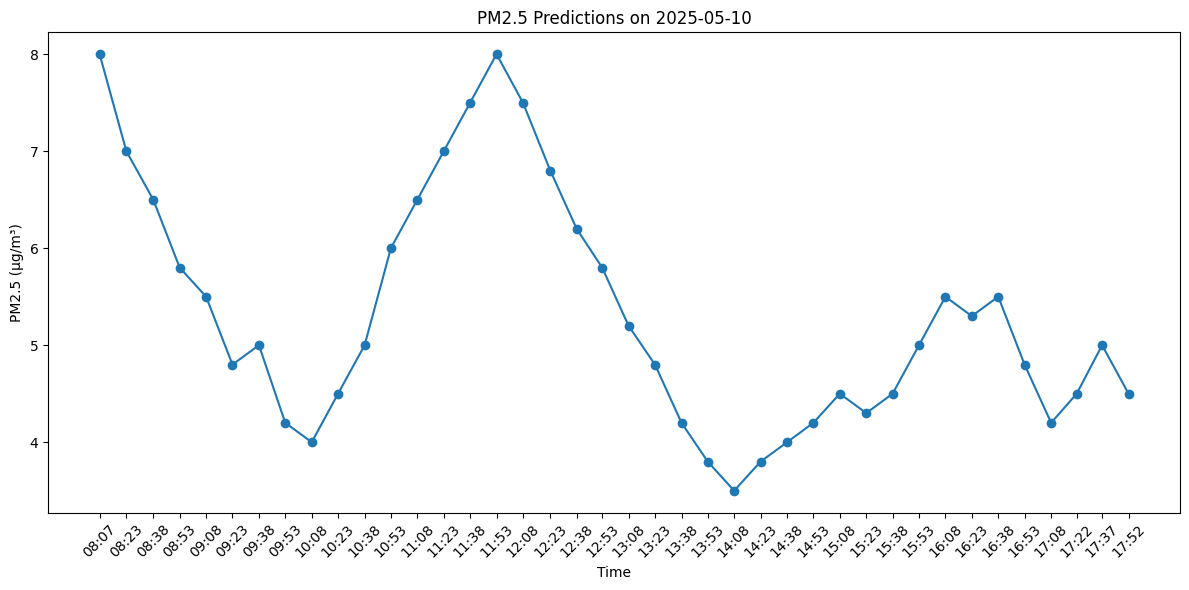

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file into a DataFrame if not already loaded
df_csv = pd.read_csv('/home/jasonrao/Documents/TCAM/pm25_predictions0.csv')

# Convert 'timestamp' to datetime for plotting
df_csv['timestamp'] = pd.to_datetime(df_csv['timestamp'])
plt.figure(figsize=(12, 6))
# Format x-axis to show only time (hh:mm) for each node
time_labels = df_csv['timestamp'].dt.strftime('%H:%M')
plt.gca().set_xticks(df_csv['timestamp'])
plt.gca().set_xticklabels(time_labels, rotation=45)
plt.plot(df_csv['timestamp'], df_csv['pm25_value'], marker='o', linestyle='-')
plt.xlabel("Time")
plt.ylabel("PM2.5 (μg/m³)")
plt.title("PM2.5 Predictions on 2025-05-10")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Get location id

In [ ]:
# Look up sensors for a given OpenAQ location_id.
# Optionally filter by pollutant name (e.g., 'pm25', 'pm10').

# Returns a list of dicts:
#   {'sensor_id', 'parameter', 'units', 'name', 'latest_value', 'latest_local'}
import requests

def sensors_for_location(api_key: str, location_id: int, parameter: str | None = None, limit: int = 3):
    headers = {"X-API-Key": api_key}
    url = f"https://api.openaq.org/v3/locations/{location_id}/sensors"

    page = 1
    out = []
    while True:
        resp = requests.get(url, headers=headers, params={"limit": limit, "page": page})
        resp.raise_for_status()
        payload = resp.json()

        results = payload.get("results", [])
        
        if parameter:
            want = parameter.lower()
            results = [s for s in results if (s.get("parameter", {}).get("name", "") or "").lower() == want]
            # print(results)

        for s in results:
            param = s.get("parameter") or {}
            latest = s.get("latest") or {}
            latest_dt = latest.get("datetime") or {}
            out.append({
                "sensor_id": s.get("id"),
                "parameter": param.get("name"),
                "units": param.get("units"),
                "name": s.get("name"),
                "latest_value": latest.get("value"),
                "latest_local": latest_dt.get("local"),
                "latest_utc": latest_dt.get("utc"),
            })

        meta = payload.get("meta", {}) or {}
        found = meta.get("found") or 0
        if not results or page * limit >= found:
            break
        page += 1

    return out

API_KEY = "829e1a1d5340d640e5f617ce26ed769a49ca86f8a3ba6bb494409e97dfa52e9d"
LOCATION_ID = 8777  # replace with your location id

all_sensors = sensors_for_location(API_KEY, LOCATION_ID)
# print(all_sensors) # Show all the info from the api call, not likely to use it

pm25_sensors = sensors_for_location(API_KEY, LOCATION_ID, parameter="pm25")
print(pm25_sensors)
if pm25_sensors:
    sensor_id = pm25_sensors[0]["sensor_id"]
    print("Use sensor_id:", sensor_id)


[{'id': 25595, 'name': 'pm25 µg/m³', 'parameter': {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'displayName': 'PM2.5'}, 'datetimeFirst': {'utc': '2016-12-02T18:00:00Z', 'local': '2016-12-02T11:00:00-07:00'}, 'datetimeLast': {'utc': '2025-09-04T19:00:00Z', 'local': '2025-09-04T13:00:00-06:00'}, 'coverage': {'expectedCount': 1, 'expectedInterval': '01:00:00', 'observedCount': 56939, 'observedInterval': '56939:00:00', 'percentComplete': 5693900.0, 'percentCoverage': 5693900.0, 'datetimeFrom': {'utc': '2016-12-02T18:00:00Z', 'local': '2016-12-02T11:00:00-07:00'}, 'datetimeTo': {'utc': '2025-09-04T19:00:00Z', 'local': '2025-09-04T13:00:00-06:00'}}, 'latest': {'datetime': {'utc': '2025-09-04T19:00:00Z', 'local': '2025-09-04T13:00:00-06:00'}, 'value': 5.8, 'coordinates': {'latitude': 40.7955, 'longitude': -111.93089999999998}}, 'summary': {'min': -4.9, 'q02': None, 'q25': None, 'median': None, 'q75': None, 'q98': None, 'max': 256.8, 'avg': 8.318526215782907, 'sd': None}}]
[{'sensor_id': 25595,

# Get PM2.5 data from a location

Plotting 11 data points between 8 AM and 6 PM
Local timestamps: ['2025-05-17 08:00:00', '2025-05-17 09:00:00', '2025-05-17 10:00:00', '2025-05-17 11:00:00', '2025-05-17 12:00:00', '2025-05-17 13:00:00', '2025-05-17 14:00:00', '2025-05-17 15:00:00', '2025-05-17 16:00:00', '2025-05-17 17:00:00', '2025-05-17 18:00:00']


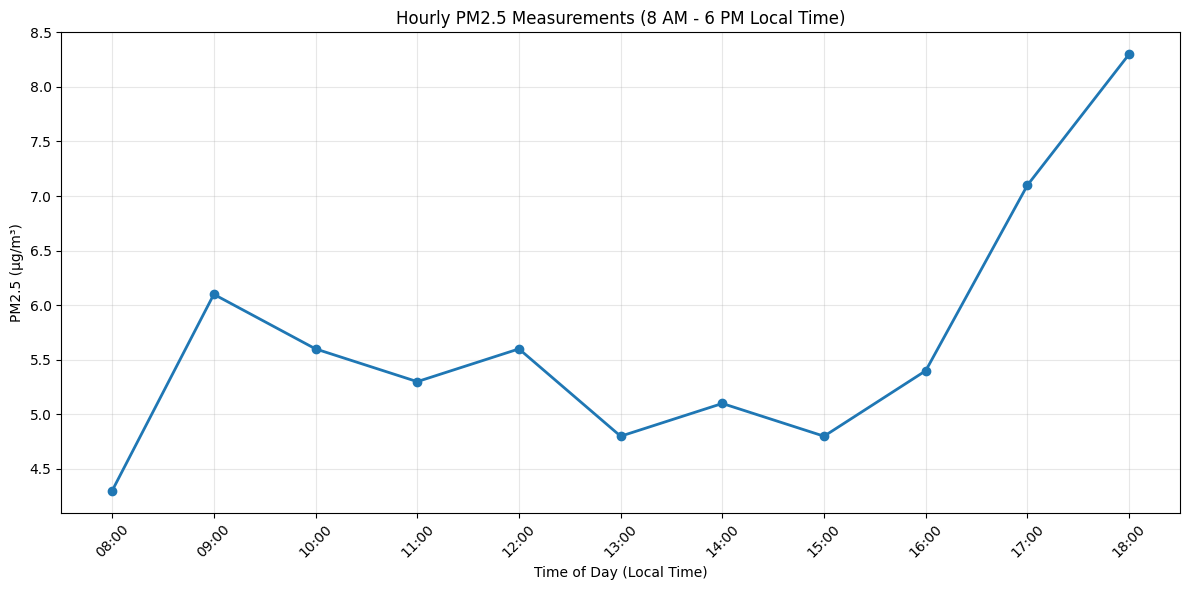

In [2]:
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

def fetch_and_plot_pm25_data(api_key, sensor_id, location_id, date_from, date_to):
    """
    Fetches PM2.5 data from OpenAQ API and plots only data between 8 AM and 6 PM
    using the datetimeLocal field directly.
    """
    # Fetch data from API
    url = f"https://api.openaq.org/v3/sensors/{sensor_id}/measurements/hourly"
    headers = {"X-API-Key": api_key}
    params = {
        "datetime_from": date_from,
        "datetime_to": date_to,
        "limit": 100
    }


    
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    data = response.json()
    
    # Process data using datetimeLocal directly
    local_data = []
    for item in data["results"]:
        local_timestamp = item["period"]["datetimeTo"]["local"]
        value = item["value"]
        
        # Parse the local datetime
        dt_local = datetime.fromisoformat(local_timestamp.replace('Z', '+00:00'))
        
        # Filter for 8 AM to 6 PM (08:00 to 18:00)
        if 8 <= dt_local.hour <= 18:
            local_data.append({
                'datetime': dt_local,
                'value': value,
                'time_label': dt_local.strftime("%H:%M")
            })
    
    # Sort by datetime
    local_data.sort(key=lambda x: x['datetime'])
    
    # Extract data for plotting
    timestamps = [item['datetime'] for item in local_data]
    values = [item['value'] for item in local_data]
    time_labels = [item['time_label'] for item in local_data]
    
    print(f"Plotting {len(local_data)} data points between 8 AM and 6 PM")
    print("Local timestamps:", [dt.strftime("%Y-%m-%d %H:%M:%S") for dt in timestamps])
    
    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, values, marker='o', linestyle='-', linewidth=2, markersize=6)
    plt.xlabel("Time of Day (Local Time)")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.title("Hourly PM2.5 Measurements (8 AM - 6 PM Local Time)")
    
    # Format x-axis to show only time
    plt.gca().set_xticks(timestamps)
    plt.gca().set_xticklabels(time_labels, rotation=45)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return timestamps, values

# Usage change the location if needed
API_KEY = "829e1a1d5340d640e5f617ce26ed769a49ca86f8a3ba6bb494409e97dfa52e9d"
SENSOR_ID = 25595
LOCATION_ID = 8777
DATE_FROM = "2025-05-17T00:00:00Z"
DATE_TO = "2025-05-18T00:00:00Z"

timestamps, values = fetch_and_plot_pm25_data(API_KEY, SENSOR_ID, LOCATION_ID, DATE_FROM, DATE_TO)

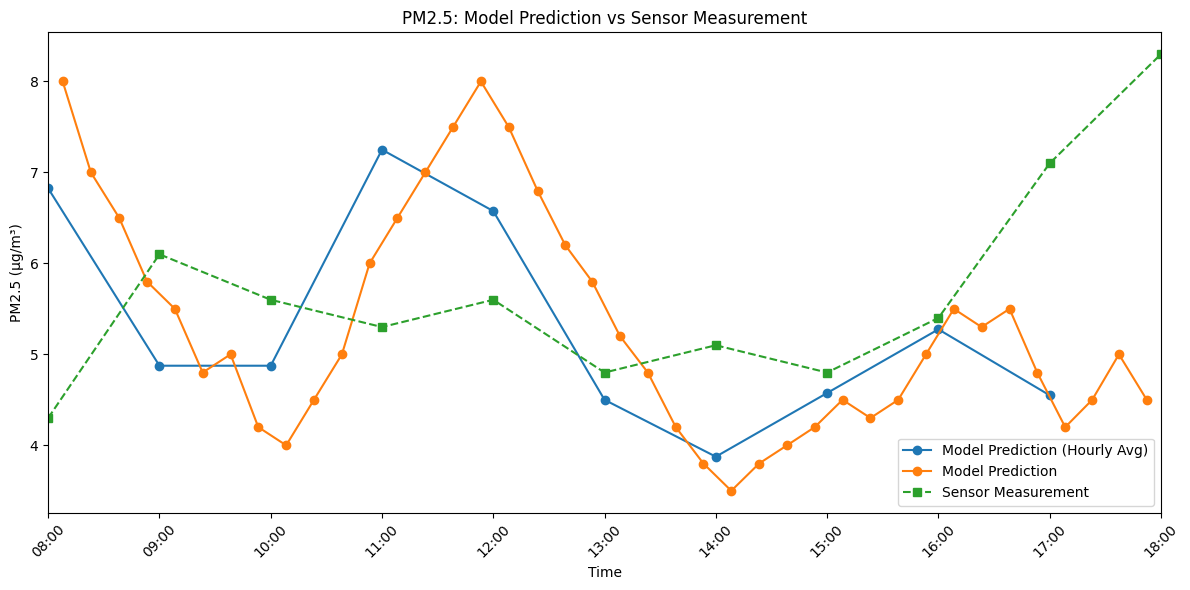

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

df_csv['timestamp'] = pd.to_datetime(df_csv['timestamp'])
df_csv_sorted = df_csv.sort_values("timestamp")
model_times = df_csv_sorted['timestamp']
model_values = df_csv_sorted['pm25_value']

sensor_times = timestamps
sensor_values = values


plt.figure(figsize=(12, 6))

df_csv_sorted['hour'] = df_csv_sorted['timestamp'].dt.floor('h')
hourly_avg = df_csv_sorted.groupby('hour')['pm25_value'].mean().reset_index()
plt.plot(hourly_avg['hour'], hourly_avg['pm25_value'], marker='o', linestyle='-', label='Model Prediction (Hourly Avg)')
plt.plot(model_times, model_values, marker='o', linestyle='-', label='Model Prediction')
plt.plot(sensor_times, sensor_values, marker='s', linestyle='--', label='Sensor Measurement')

time_labels = [t.strftime('%H:%M') for t in model_times]
plt.gca().set_xticks([t for t in model_times if (t.hour >= 8 and t.hour <= 18)])
plt.xlim([model_times.iloc[0].replace(hour=8, minute=0, second=0), model_times.iloc[0].replace(hour=18, minute=0, second=0)])
plt.gca().set_xticklabels(time_labels, rotation=45)
plt.xlabel("Time")
plt.ylabel("PM2.5 (μg/m³)")
hour_range = pd.date_range(
    start=model_times.iloc[0].replace(hour=8, minute=0, second=0),
    end=model_times.iloc[0].replace(hour=18, minute=0, second=0),
    freq="h"
)
plt.gca().set_xticks(hour_range)
plt.gca().set_xticklabels([t.strftime('%H:%M') for t in hour_range], rotation=45)
plt.xlim([hour_range[0], hour_range[-1]])
plt.title("PM2.5: Model Prediction vs Sensor Measurement")
plt.legend()
plt.tight_layout()
plt.show()